In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from uavsar_pytools.snow_depth_inversion import depth_from_phase
from stats import get_stats, clean_xs_ys
from pathlib import Path
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subsets = gpd.read_file(Path('~/scratch/data/uavsar/lidar/subset/date.shp').expanduser())
lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/')
figdir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures')

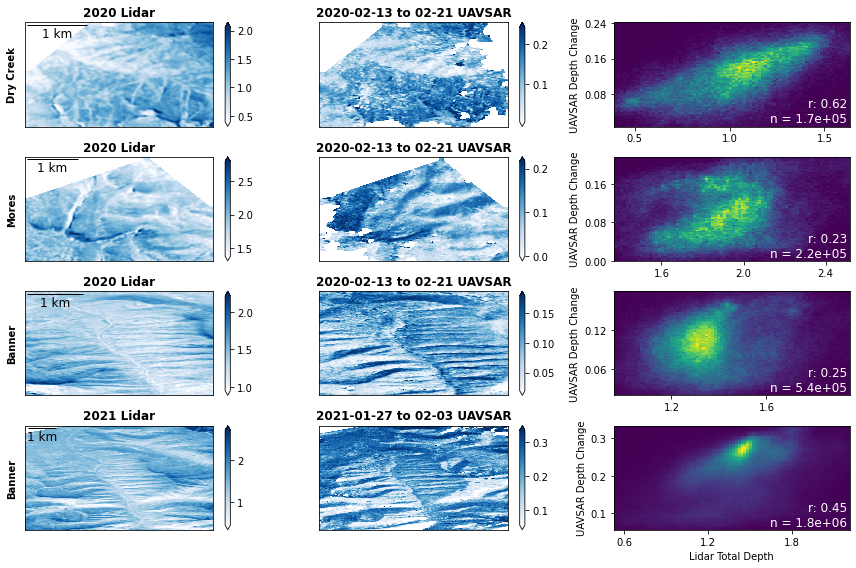

In [7]:
fig, axes = plt.subplots(4, 3, figsize = (12, 8))

for i, (_, sub) in enumerate(subsets.iterrows()):
    loc, year = sub.date.split('-')
    lidar = xr.open_dataset(lidar_dir.joinpath(loc).with_suffix('.sd.nc'))

    if sub.id == 3 or sub.id == 5:
        xmin, ymin, xmax, ymax = sub.geometry.bounds
        from shapely.geometry import box
        subset = lidar.rio.clip_box(*box(xmin + 0.02, ymin, xmax - 0.02, ymax).bounds)
    else:
        subset = lidar.rio.clip_box(*sub.geometry.bounds)
    subset = subset.sortby('y')
    if year == '2020':
        if loc != 'Dry_Creek':
            lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[0])
        else:
            lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times)
        
        if loc == 'Mores':
            uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)
            t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 3)['time2']
        else:
            uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)
            t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 2)['time2']
            
    if year == '2021':
        lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[1])
        uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)
        t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 7)['time2']
    
    t1, t2 = t1.dt.strftime('%Y-%m-%d').values, t2.dt.strftime('%m-%d').values

    # filter
    lidar_sub.data = gaussian_filter(lidar_sub.data, 3)

    uv_sub = uv_sub.where(~lidar_sub.isnull())
    uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'x')
    uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'y')
    uv_sub.data = gaussian_filter(uv_sub.data, 1)

    lidar_sub.plot(ax = axes[i, 0], vmin = lidar_sub.quantile(0.01), vmax = lidar_sub.quantile(0.999), cmap = 'Blues', cbar_kwargs={'label': None})
    uv_sub.plot(ax = axes[i, 1], vmin = uv_sub.quantile(0.01), vmax = uv_sub.quantile(0.99), cmap = 'Blues', cbar_kwargs={'label': None})

    # get r and n
    rmse, r, n, bias = get_stats(lidar_sub, uv_sub, bias = True)
    axes[i, 2].text(.99, .01, f'r: {r:.2}\nn = {n:.1e}', ha = 'right', va = 'bottom', transform = axes[i, 2].transAxes, color = 'white', fontsize = 12)

    xs, ys = clean_xs_ys(lidar_sub, uv_sub)
    axes[i, 2].hist2d(xs, ys, bins = 80, range = [np.quantile(xs, [0.01, 0.99]), np.quantile(ys, [0.01, 0.99])])

    # if i == 0:
    #     axes[0, 0].set_title(f"Lidar", weight = 'bold')
    #     # axes[0, 2].set_title('')
    # else:
    #     axes[i, 0].set_title('')
    axes[i, 0].set_title(f"{year} Lidar", weight = 'bold')
    axes[i, 1].set_title(f"{t1} to {t2} UAVSAR", weight = 'bold')

    axes[i, 0].set_ylabel(f"{loc.replace('_', ' ')}", weight="bold")
    axes[i, 1].set_ylabel('')

    import matplotlib.font_manager as fm
    fontprops = fm.FontProperties(size=12)

    scalebar = AnchoredSizeBar(axes[i, 0].transData,
                           0.009009009009009009, '1 km', 'upper left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=0.00003,
                           fontproperties=fontprops)

    axes[i, 0].add_artist(scalebar)

    

for ax in axes[:, :2].ravel():
    ax.set_xlabel('')
    # ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes[:, 2].ravel():
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_ylabel('UAVSAR Depth Change')
axes[3, 2].set_xlabel('Lidar Total Depth')

plt.tight_layout()
plt.savefig(figdir.joinpath('lidar', 'subset', 'quad-lidar-img_v2.png'))

In [317]:
def get_condition_r(low, high, veg = False, incidence_angle = False, coherence = False, elevation = False):
    xs = []
    ys = []

    for i, (_, sub) in enumerate(subsets.iterrows()):

        
        loc, year = sub.date.split('-')
        lidar = xr.open_dataset(lidar_dir.joinpath(loc).with_suffix('.sd.nc'))

        if sub.id == 3 or sub.id == 5:
            xmin, ymin, xmax, ymax = sub.geometry.bounds
            from shapely.geometry import box
            subset = lidar.rio.clip_box(*box(xmin + 0.02, ymin, xmax - 0.02, ymax).bounds)
        else:
            subset = lidar.rio.clip_box(*sub.geometry.bounds)
        subset = subset.sortby('y')
        dem = subset['lidar-dem']
        if year == '2020':
            if loc != 'Dry_Creek':
                lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[0])
                vh = subset['lidar-vh'].sel(time = subset.lidar_times[0])
            else:
                lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times)
                vh = subset['lidar-vh'].sel(time = subset.lidar_times)
            
            if loc == 'Mores':
                uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)
                cor = subset['232-cor'].sel(band = 'VV').isel(time = 3)
                inc = subset['232-inc'].isel(time = 3)
                t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 3)['time2']
            else:
                uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)
                cor = subset['232-cor'].sel(band = 'VV').isel(time = 2)
                inc = subset['232-inc'].isel(time = 2)
                t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 2)['time2']
                
        if year == '2021':
            lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[1])
            vh = subset['lidar-vh'].sel(time = subset.lidar_times[1])
            uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)
            inc = subset['232-inc'].isel(time = 7)
            cor = subset['232-cor'].sel(band = 'VV').isel(time = 7)
            t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 7)['time2']
        
        t1, t2 = t1.dt.strftime('%Y-%m-%d').values, t2.dt.strftime('%m-%d').values

        # filter
        lidar_sub.data = gaussian_filter(lidar_sub.data, 3)

        uv_sub = uv_sub.where(~lidar_sub.isnull())
        uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'x')
        uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'y')
        uv_sub.data = gaussian_filter(uv_sub.data, 1)

        if veg:
            cond = vh
        if incidence_angle:
            cond = np.rad2deg(inc)
        if coherence:
            cond = cor
        if elevation:
            cond = dem

        lidar_sub_cond = lidar_sub.where((cond < high) & (cond > low))

        uv_sub_cond = uv_sub.where((cond < high) & (cond > low))
        
        xs.extend(lidar_sub_cond)
        ys.extend(uv_sub_cond)
    


        
        # get r and n
    rmse, r, n, = get_stats(xs, ys)

    return r

In [365]:
def get_melt_r(low, high):
    
    xs = []
    ys = []

    for i, (_, sub) in enumerate(subsets.iterrows()):

        
        loc, year = sub.date.split('-')
        lidar = xr.open_dataset(lidar_dir.joinpath(loc).with_suffix('.sd.nc'))

        if sub.id == 3 or sub.id == 5:
            xmin, ymin, xmax, ymax = sub.geometry.bounds
            from shapely.geometry import box
            subset = lidar.rio.clip_box(*box(xmin + 0.02, ymin, xmax - 0.02, ymax).bounds)
        else:
            subset = lidar.rio.clip_box(*sub.geometry.bounds)
        subset = subset.sortby('y')
        dem = subset['lidar-dem']
        if year == '2020':
            if loc != 'Dry_Creek':
                lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[0])
            else:
                lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times)
            
            if loc == 'Mores':
                uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)
                t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 3)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 3)['time2']
            else:
                uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)
                t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 2)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 2)['time2']
                
        if year == '2021':
            lidar_sub = subset['lidar-sd'].sel(time = subset.lidar_times[1])
            uv_sub = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)
            t1, t2 = subset['232-sd_delta_unw'].sel(band = 'VV').isel(time = 7)['time'], subset['232-sd_delta_int'].sel(band = 'VV').isel(time = 7)['time2']
        
        t1, t2 = t1.dt.strftime('%Y-%m-%d').values, t2.dt.strftime('%Y-%m-%d').values

        modeldir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/model/')
        modeldir.joinpath(f'sm_smlt_{year}{pd.to_datetime(t1.reshape(1)[0]).month}.nc')

        # filter
        lidar_sub.data = gaussian_filter(lidar_sub.data, 3)

        uv_sub = uv_sub.where(~lidar_sub.isnull())
        uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'x')
        uv_sub = uv_sub.interpolate_na(method = 'quadratic', limit = 10, dim = 'y')
        uv_sub.data = gaussian_filter(uv_sub.data, 1)

        # get melt
        modeldir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/model/')
        # model = xr.open_dataset(modeldir.joinpath(f"232_{t1}_{t2}.sd.model.nc"))
        model = xr.open_dataset(modeldir.joinpath('model.re.nc'))
        model = model.rio.write_crs('EPSG:4326')
        uv_model = model.sel(time = slice(t1, t2))
        melt = uv_model['melt'].sum(dim = 'time')
        melt = melt.rio.reproject_match(uv_sub)

        cond = melt

        lidar_sub_cond = lidar_sub.where((cond < high) & (cond > low))

        uv_sub_cond = uv_sub.where((cond < high) & (cond > low))
        
        xs.extend(lidar_sub_cond)
        ys.extend(uv_sub_cond)

        # get r and n
    rmse, r, n, = get_stats(xs, ys)

    return r

melt: 100%|██████████| 16/16 [01:13<00:00,  4.61s/it]


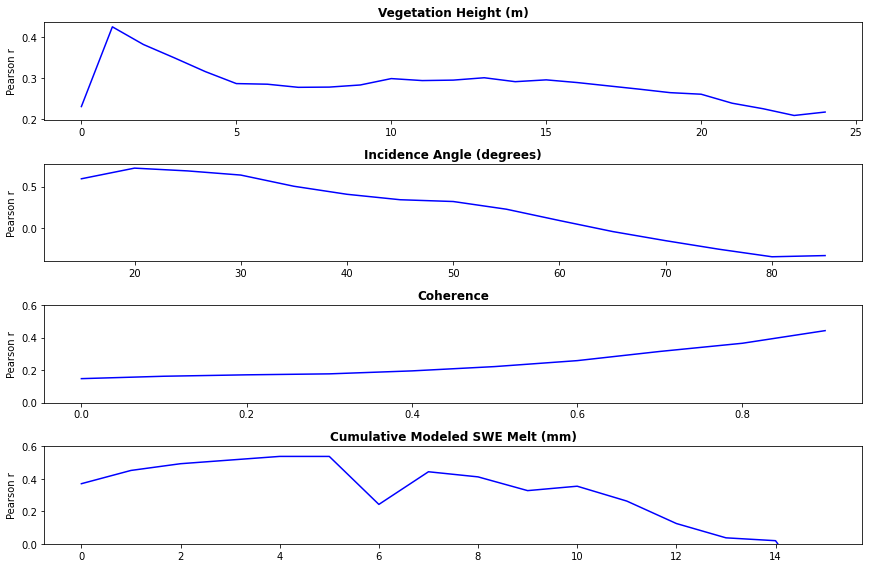

In [389]:
fig, axes = plt.subplots(4, 1, figsize = (12, 8))

# tree filter
step = 1 # 1
start = 0
end = 25
tree_xs = []
tree_rs = []

for low, high in tqdm(zip(range(start, end, step), range(start + step, end + step, step)), total = len(range(start + step, end + step, step)), desc = 'veg'):
    try:
        r = get_condition_r(low, high, veg = True)
    except ValueError as ve:
        continue
    tree_xs.append(low)
    tree_rs.append(r)

axes[0].plot(tree_xs, tree_rs, color = 'blue')

axes[0].set_title('Vegetation Height (m)', weight = 'bold')

# inc filter
step = 5 # 5
start = 0
end = 90
inc_xs = []
inc_rs = []

for low, high in tqdm(zip(range(start, end, step), range(start + step, end + step, step)), total = len(range(start + step, end + step, step)), desc = 'inc'):
    try:
        r = get_condition_r(low, high, incidence_angle = True)
    except ValueError as ve:
        continue
    inc_xs.append(low)
    inc_rs.append(r)

axes[1].plot(inc_xs, inc_rs, color = 'blue')

axes[1].set_title('Incidence Angle (degrees)', weight = 'bold')

# cor filter
step = 0.1 # .1
start = 0
end = 1
cor_xs = []
cor_rs = []

for low, high in tqdm(zip(np.arange(start, end, step), np.arange(start + step, end + step, step)), total = len(np.arange(start + step, end + step, step)), desc = 'cor'):
    try:
        r = get_condition_r(low, high, coherence = True)
    except ValueError as ve:
        continue
    cor_xs.append(np.round(low, 2))
    cor_rs.append(r)

axes[2].plot(cor_xs, cor_rs, color = 'blue')

axes[2].set_title('Coherence', weight = 'bold')

# melt filter
step = 0.001 # 100
start = 0
end = 0.016
melt_xs = []
melt_rs = []

for low, high in tqdm(zip(np.arange(start, end, step), np.arange(start + step, end + step, step)), total = len(np.arange(start + step, end + step, step)), desc = 'melt'):
    try:
        r = get_melt_r(low, high)
    except ValueError as ve:
        print(f'{low} to {high} error:')
        print(ve)
        continue
    melt_xs.append(np.round(low * 1000, 2))
    melt_rs.append(r)

axes[3].plot(melt_xs, melt_rs, color = 'blue')

axes[3].set_title('Cumulative Modeled SWE Melt (mm)', weight = 'bold')

plt.tight_layout()

for ax in axes:
    ax.set_ylabel('Pearson r')

for ax in axes[2:]:
    ax.set_ylim(0, 0.6)

plt.savefig(figdir.joinpath('lidar', 'subset', 'lidar-r-params_v3.png'))

In [370]:
modeldir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/model/')
model = xr.open_dataset(modeldir.joinpath('model.re.nc'))

In [374]:
model.sel(time = slice(t1, t2))['melt'].sum(dim = 'time').max()

<xarray.DataArray 'melt' ()>
array(1.92674757)